# Shor's Algorithm

This notebook will implement Shor's Algorithm to factor a given number $N$  
Created by George Lake - December 2025

Consisting of :  
- 1: Imports and Configuration  
        Imports, Define target, calculate qubits  
- 2: Classical Pre-Checks  
        Verify N is odd, composite, not a prime power, compute gcd
- 3: Quantum Arithmetic Library
       Define $U_a$, QFT Adder, Modular Adder, Controlled Modular Multiplier
- 4: Circuit Construction
        Phase register, work register, Hadamard, controlled modular multipliers, Inverse QFT
- 5: Execution and Measurement on Simulator
        Transpile, Measure, Simulate and Approximate phase $\frac{s}{r}$
- 5a: Execution and Measurement on IBM Quantum Computer - OPTIONAL
        All stuff needed to do this...
- 6: Classical Post-Processing
        Use Continued Fractions algorithm, Validate $r$
- 7: Factor Extraction
        Compute factors using the greatest common divisor, output results.

# 1. Imports and Configuration

In this section, we set up the environment. Since we are building a generalized solver, we need to establish the variables $N$ (the number to factor) and $a$ (the random guess) as dynamic inputs rather than hardcoded circuit values.

**NOTE**: $N$ contains the number to factor. Change it to the number you want to factor. Since this is simulated on a classical computer, it should be below 30 digits.

In [1]:
# Imports and Configuration
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction
import math

# Qiskit Core primitives
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qasm2

# Qiskit Visualization
from qiskit.visualization import plot_histogram

# Qiskit Aer (The Simulator)
from qiskit_aer import AerSimulator

# Qiskit Standard Library
from qiskit.circuit.library import QFTGate, UnitaryGate

print("Libraries imported successfully")

Libraries imported successfully


## Configuration of Target $N$

Here we define the problem instance
* **$N$**: The odd composite integer we want to factor.
* **$a$**: The random integer such that $1 < a < N$ and $gcd(a, N) = 1$
* **$n$**: The number of bits required to represent $N$ in binary. This determines the size of our registers
* **$t$**: The number of bits for the phase register

According to Shor's Algorithm requirements:
1. **Work Register (Eigenstate)**: Needs to hold the number $N$, so it requires $n = \lceil \log_2 N \rceil$ qubits.
2. **Phase Register (Counting)**: Needs high precision to estimate the phase. Standard implementation requires $t = 2n$ qubits

In [2]:
# --- User Configuration ---
N = 33
a = 7

# --- Logic ---
# Calculate n: 
# equivalent to ceil(log2(N))
n = N.bit_length()

# Calculate t
t = 2 * n

print(f"Target N: {N}")
print(f"Guess a: {a}")
print(f"Required bits for N (n): {n}")
print(f"Precision bits (t): {t}")
print(f"Total logical qubits required: {n + t}")

# Sanity check for simulation
if (n + t) > 30:
    print("WARNING: This circuit requires > 30 qubits. Simulation on a local machine may crash or hang")
else:
    print("STATUS: Qubit count is within safe simulation limits.")

Target N: 33
Guess a: 7
Required bits for N (n): 6
Precision bits (t): 12
Total logical qubits required: 18
STATUS: Qubit count is within safe simulation limits.


# 2. Classical Pre-Checks

Before running the quantum circuit, we must verify that $N$ is a valid candidate for Shor's Algorithm. The algorithm is designed for odd composite numbers that are not powers of primes.  

**We perform three checks**
1. **Parity Check**: If $N$ is even, the factor is 2
2. **GCD Check**: If $gcd(a,N) > 1$, we have already found a non-trivial factor
3. **Perfect Power Check**: If $N = x^y$ for integers $x, y > 1$, efficient classical algorithms exist to solve this, and Shor's algorithm is not required.

In [3]:
def check_perfect_power(n):
    """
    Checks if n can be written as x^y for integers x, y > 1.
    Returns (True, x, y) if a perfect power is found, otherwise (False, None, None)
    """
    # Test exponents y starting from 2 up to log2(n)
    if n <= 1:
        return False, None, None

    log_n = math.log2(n)
    max_exponent = int(log_n)

    for y in range(2, max_exponent + 1):
        #Calculate the y-th root of n
        x = round(n ** (1 / y))
        if x ** y == n:
            return True, x, y
            
    return False, None, None

In [4]:
# Perform Checks
print(f"--- Running Classical Pre-Checks for N={N}, a={a} ---")

# 1. Parity Check
if N % 2 == 0:
    print(f"Check Failes: N={N} is even. Factor is 2")
    print("Stopping execution")
else:
    print(f"1. Parity passed: {N} is odd.")

# 2. GCD Check
common_factor = math.gcd(a, N)
if common_factor > 1:
    print(f"Check Failed: gcd({a}, {N}) = {common_factor}.")
    print(f"Found factor purely by luck: {common_factor}")
    print("Stopping execution")
else:
    print(f"2. GCD passed: gcd({a}, {N}) = 1")

# 3. Perfect Power Check
is_power, base, exponent = check_perfect_power(N)
if is_power:
    print(f"Check Failed: N={N} is a perfect power ({base}^{exponent}).")
    print("Shor's algorithm is not required.")
else:
    print(f"3. Power check passed: {N} is not a perfect power.")

print("\nAll classical checks passed. Proceed to quantum circuit construction.")

--- Running Classical Pre-Checks for N=33, a=7 ---
1. Parity passed: 33 is odd.
2. GCD passed: gcd(7, 33) = 1
3. Power check passed: 33 is not a perfect power.

All classical checks passed. Proceed to quantum circuit construction.


# 3. The Quantum Arithmetic Library

In this step, we build the core components of the quantum circuit. According to the outline, we need two specific tools.
1. **The Inverse OFT**: To extract information from the phase register
2. **The Controlled Modular Multiplier ($U$)**: To perform the operation $a^{2^k} \pmod{N}$

To make this solver work for any $N$ without needing thousands of gates, we will implement the modular exponentiation by generating the **unitary matrix** for the operation and converting it into a gate. This is the most robust method for simulation

**Implementation Note**:
For a general $N$, constructing this circuit from individual gates (CNOTs) is extremely complex.  
To ensure this notebook works for any input $N$, we will generate a permutation matrix corresponding to multiplication by $a \pmod N$ and convert it directly into a quantum gate.



## 3.1 Inverse Quantum Fourier Transform (QFT $^{\dagger}$}

The phase estimation algorithm requires us to apply the Inverse QFT to the counting register at the end of the circuit to transform the phase information back into a measurable binary number.

In [5]:
def get_inverse_qft_gate(num_qubits):
    """
    Returns the Inverse Quantum Fourier Transform gate for a specific number of qubits
    Qiskit provides a highly optimized QFT library, we use that
    """
    qft_gate = QFTGate(num_qubits)
    return qft_gate.inverse()
    

In [6]:
# FUTURE:
# IMPLEMENT MANUAL QFT, to see what it looks like

## 3.2 Controlled Modular Exponentiation (The Oracle)

This is the heart of Shor's algorithm. We need a unitary operation $U$ that performs:
$$U\ket{y} = \ket{ay \pmod{N}}$$
We must apply this operation efficiently for powers of $a : a^{2^0}, a^{2^1}, \dots a^{2^{t-1}}$ 

In [7]:
def c_amodN(a, power, N, n_qubits):
    """
    Creates a Controlled Unitary Gate that performs multiplication by a^power mod N.
    Target: |y> -. |(a^power * y) mod N>
    """
    # 1. Calculate the standard matrix for the operation "multiply by k mod N"
    # The matrix size is 2^n_qubits  x 2^n_qubits
    U_matrix = np.zeros((2**n_qubits, 2**n_qubits))

    # Compute the effective multiplier: k = a^power mod N
    k = pow(a, power, N)

    for i in range(2**n_qubits):
        # Process every possible state |i> in the computational basis
        if i < N:
            # If the state represetns a number < N, transform it
            result = (i * k) % N
            U_matrix[result][i] = 1
        else:
            # If the state is >= N (garbage states), leave it alone
            U_matrix[i][i] = 1

    # 2. Convert the matrix to a Quantum Gate
    U_gate = UnitaryGate(U_matrix, label=f"{a}^{power} mod {N}")

    # 3. Create the Controlled version (C-U)
    c_U_gate = U_gate.control(1)

    return c_U_gate
            

# 4. Circuit Construction

This is where we will assemble the full circuit. We will create the registers, apply the superposition, attach the modular exponentiation oracle, and apply the inverse QFT to prepare for measurement

In total, this is the Phase Estimation Circuit:

**Workflow**
1. **Initialize Registers**:
    * `Phase Register` (t qubits): Initialized to $\ket{0}$
    * `Work Register` (n qubits): Initialized to $\ket{1}$ - the eigenstate of the unitary
3. **Superposition**: Apply Hadamard gates $(H)$ to all qubits in the Phase Register
4. **Oracle Application**: Apply the controlled unitary operations $U^{2^j}$ sequentially.
    * For each qubit $j$ in the phase register, we apply a controlled modular multiplication $a^{2^j} \pmod N$
5. **Inverse QFT**: Apply $QFT^{\dagger}$ to the Phase Register to unravel the phase information
6. **Measurement**: Add measurement instructions
7. **Visualize**: This should only be ran on small circuits. Even with 3 digit numbers it breaks

Oracle applied
Inverse QFT applied.
Measurement instructions added.


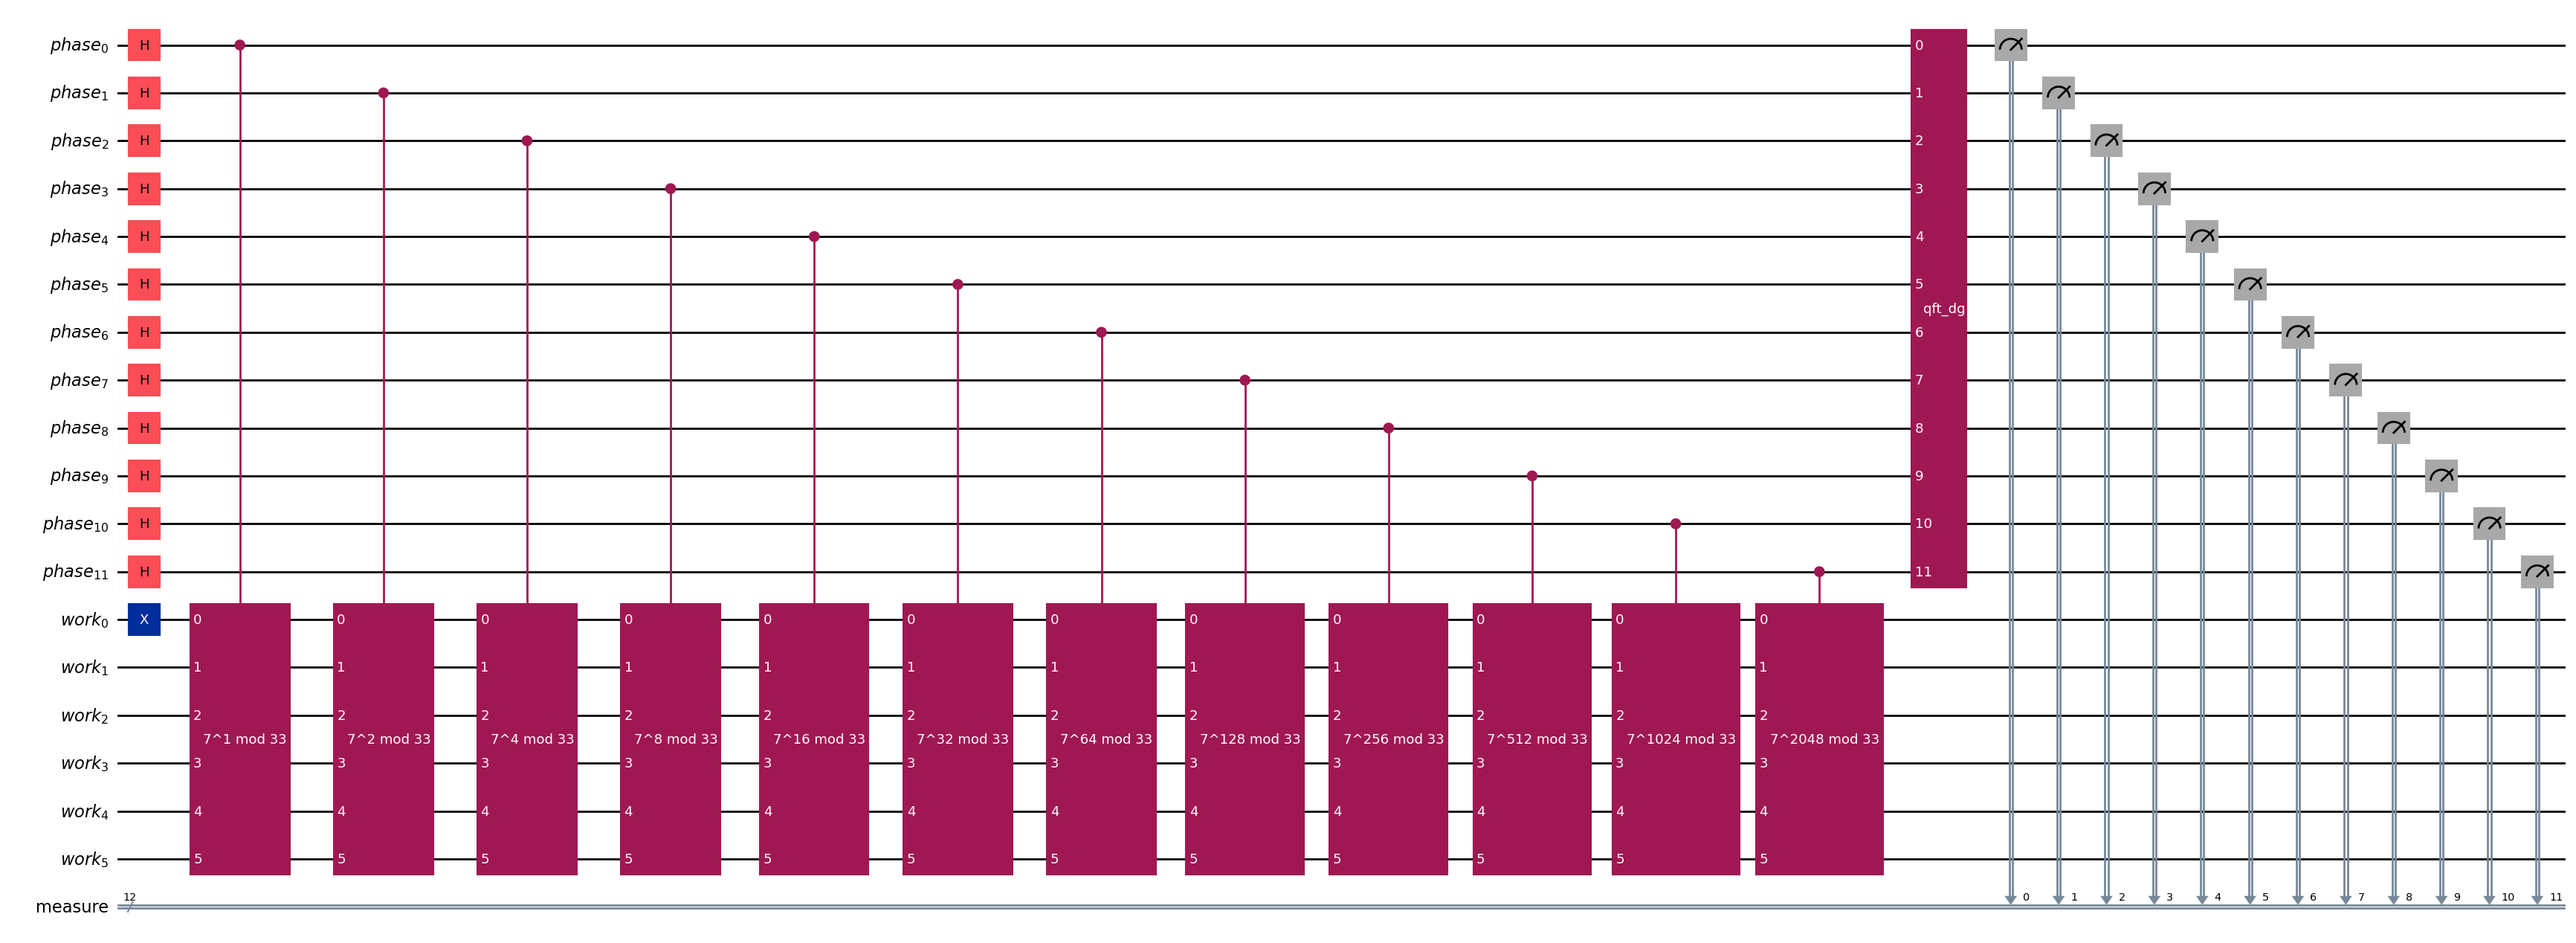

In [8]:
# --- 1. Initialize Registers ---
# Phase Register (Counting Qubits)
qr_phase = QuantumRegister(t, name="phase")

# Work Register (Eigenstate Qubits)
qr_work = QuantumRegister(n, name="work")

# Classical Register (measurment results)
cr_phase = ClassicalRegister(t, name="measure")

# Create Circuit and Initialize
qc = QuantumCircuit(qr_phase, qr_work, cr_phase)
qc.x(qr_work[0])

# --- 2. Superposition ---
qc.h(qr_phase)

# --- 3. Apply the Oracle (Controlled Modular Exponentiation) ---
# Iterate through each qubit in the phase register
# For the qubit at index 'i', apply unitary raised to 2^i
# U^(2^i) corresponds to multiplying by a^(2^i) mod N
for i in range(t):
    exponent = 2**i
    c_u_gate = c_amodN(a, exponent, N, n)
    qc.append(c_u_gate, [qr_phase[i]] + list(qr_work))
print("Oracle applied")

# --- 4. Apply Inverse QFT ---
qc.append(get_inverse_qft_gate(t), qr_phase)
print("Inverse QFT applied.")

# --- 5. Measurement ---
qc.measure(qr_phase, cr_phase)
print("Measurement instructions added.")

# --- 6. Draw the Circuit (OPTIONAL) ---
qc.draw(output='mpl', fold=-1)

# Export QASM string
# try:
#     qasm_str = qasm2.dumps(qc)
#     filename = f"shor_circuit_n{N}.qasm"
    
#     with open(filename, "w") as f:
#         f.write(qasm_str)
    
#     print(f"\nSUCCESS: Circuit QASM saved to '{filename}'.")
#     print(f"Instructions (lines): {len(qasm_str.splitlines())}")

# except Exception as e:
#     print(f"Could not generate QASM: {e}")
    


# 5. Execution and Measurement - Simulator

In this step, we take the constructed circuit and run it on a local simulator. The output will be a histogram of bitstrings, these bitstrings represent the approximations of the phase $s/r$

This will be accomplished using the `AerSimulator`
**The Process**:
1. **Transpilation**: Convert high-level gates (like the $U$ matrix) into specific basis gates supported by the simulator.
2. **Execution**: Run the circuit for a specified number of "shots" (repetitions). Because quantum mechanics is probabilistic, more shots create more probable outcomes.
3. **Visualization**: Plot the results. Expecting to see distinct "peaks" in the histogram. These peaks correspond to the phases that will reveal the period $r$.

Simulation complete. Total shots: 2048
Number of unique bitstrings measured: 102


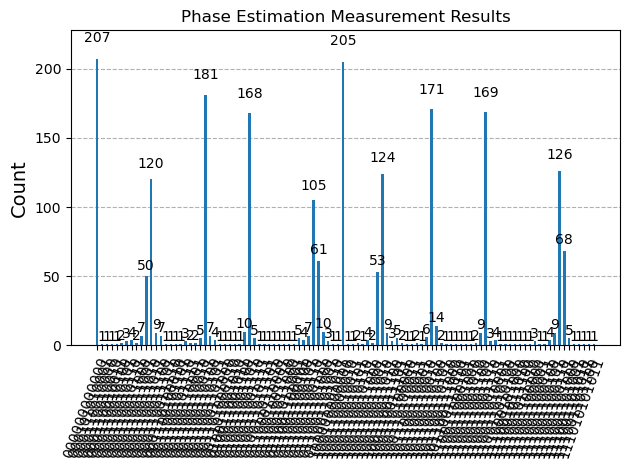

In [9]:
# --- 1. Setup Simulator ---
simulator = AerSimulator()

# --- 2. Transpile ---
# Optimization level 2 or 3 is good for reducing gate count
t_qc = transpile(qc, simulator)

# --- 3. Execute ---
# Use a high number of shots to ensure the peaks stand out.
shots = 2048
job = simulator.run(t_qc, shots=shots)

# --- 4. Get Results ---
result = job.result()
counts = result.get_counts()

print(f"Simulation complete. Total shots: {shots}")
print(f"Number of unique bitstrings measured: {len(counts)}")

# --- 5. Visualize ---
display(plot_histogram(counts, title="Phase Estimation Measurement Results"))

## Interpreting the Histogram

There should be a few tall bars (high probability states) and potentially some low "noise" bars.  
* **The Tall Bars**: These bitstrings are the measured values $m$.
* **The Relationship**: Each $m$ relates to the period $r$ via the approximation:
    $$\frac{m}{2^t} \approx \frac{s}{r}$$
where $t$ is the number of qubits in the phase register and $s$ is some integer $\theta \le s < r$

# 6. Classical Post-Processing

This is the mathematical heavy lifting that translates the quantum measurements into the period $(r)$. The quantum computer gives a hint $(\frac{m}{2^t})$, and now we use classical number theory to exact the fraction.  
To process the results:  
1. **Convert to Phase**: For each measured value $m$, calculate the phase $\theta = \frac{m}{2^t}$
2. **Continued Fractions**: $\theta$ is an approximation of $\frac{s}{r}$, so now use the **Continued Fractions Algorithm** to find the closest fraction where the denominator $r < N$.
3. **Validation**: Check if the candidate $r$ is the actual period by verifying:
    $$a^r \equiv 1 \pmod{N}$$

In [10]:
# Look at the most probable outcomes form the simulation
# Sort counts by probability (decending)
sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)
print(f"--- Processing Top Measurements ---")
potential_periods = set()

# Iterate through the top 20 results (or fewer if fewer unique results exist)
for i, (bitstring, count) in enumerate(sorted_counts[:20]):

    # 1. Convert bitstring to integer m
    measured_int = int(bitstring, 2)

    # 2. Calculate the phase phi = m / 2^t
    phase = measured_int / (2**t)

    # 3. Continued Fractions Algorithm
    frac = Fraction(phase).limit_denominator(N)
    r_candidate = frac.denominator
    s_candidate = frac.numerator
    print(f"Measure: {bitstring} ({measured_int}) -> Phase: {phase:.4f} -> Fraction: {s_candidate}/{r_candidate} (r={r_candidate})")

    # 4. Verification: Is r_candidate actually the period? Use a^r = 1 mod N
    if pow(a, r_candidate, N) == 1:
        potential_periods.add(r_candidate)
        print(f"Verified, {r_candidate} is a valid period")
    else:
        print(f"Failed: {a}^{r_candidate} = {pow(a, r_candidate, N)} (mod {N}) != 1")

print("\n-------------------------------------------------------")
if potential_periods:
    print(f"Found valid period(s): {potential_periods}")
else:
    print(f"No valid period found. Try increasing shots or qubit precision")

--- Processing Top Measurements ---
Measure: 000000000000 (0) -> Phase: 0.0000 -> Fraction: 0/1 (r=1)
Failed: 7^1 = 7 (mod 33) != 1
Measure: 100000000000 (2048) -> Phase: 0.5000 -> Fraction: 1/2 (r=2)
Failed: 7^2 = 16 (mod 33) != 1
Measure: 001100110011 (819) -> Phase: 0.2000 -> Fraction: 1/5 (r=5)
Failed: 7^5 = 10 (mod 33) != 1
Measure: 101100110011 (2867) -> Phase: 0.7000 -> Fraction: 7/10 (r=10)
Verified, 10 is a valid period
Measure: 110011001101 (3277) -> Phase: 0.8000 -> Fraction: 4/5 (r=5)
Failed: 7^5 = 10 (mod 33) != 1
Measure: 010011001101 (1229) -> Phase: 0.3000 -> Fraction: 3/10 (r=10)
Verified, 10 is a valid period
Measure: 111001100110 (3686) -> Phase: 0.8999 -> Fraction: 9/10 (r=10)
Verified, 10 is a valid period
Measure: 100110011010 (2458) -> Phase: 0.6001 -> Fraction: 3/5 (r=5)
Failed: 7^5 = 10 (mod 33) != 1
Measure: 000110011010 (410) -> Phase: 0.1001 -> Fraction: 1/10 (r=10)
Verified, 10 is a valid period
Measure: 011001100110 (1638) -> Phase: 0.3999 -> Fraction: 2/5

# 7. Factor Extraction - THE FINALE!!!

Now that we have the period $r$, we can finally calculate the factors $p$ and $q$.

**The Algorithm**
1. **Parity Check**: Ensure $r$ is even. If $r$ is odd, cannot proceed
2. **Trivial Factor Check**: Ensure $a^{r/2} \not\equiv -1 \pmod{N}$
3. **GCD Calculation**: Compute the factors using the greatest common divisor
    * $p = gcd(a^{r/2} - 1, N)$
    * $q = gcd(a^{r/2} + 1, N)$

In [11]:
# Iterate through the verified periods
factors_found = set()

for r in potential_periods:
    print(f"\nAttempting to factor using period r={r}...")

    # 1. Check if r is even
    if r % 2 != 0:
        print("Failed: Period r is odd")
        continue

    # 2. Calculate x = a^(r/2) mod N
    x = pow(a, r // 2, N)
    print(f"Calculated x = a^(r/2) mod N = {x}")

    # 3. Check for trivial factors (x + 1 must not be a multiple of N)
    if (x + 1) % N == 0:
        print("Failed: Trivial factor case (x = -1 mod N).")
        continue

    # 4. Compute GCDs
    p = math.gcd(x - 1, N)
    q = math.gcd(x + 1, N)
    print(f"Resulting GCDs: p={p}, q={q}")

    # 5. Verify non-trivial factors
    if p not in [1, N]:
        factors_found.add(p)
    if q not in [1, N]:
        factors_found.add(q)

print("\n============================================================")
if factors_found:
    print(f"Success! Factors of {N} are: {factors_found}")

    # Final Verification
    product = 1
    for f in factors_found:
        product *= f
    if len(factors_found) == 2 and product == N:
        print(f"Verification: {list(factors_found)[0]} * {list(factors_found)[1]} == {N}")
else:
    print("Optimization failed to find factors. Try a different 'a' or more shots.")


Attempting to factor using period r=10...
Calculated x = a^(r/2) mod N = 10
Resulting GCDs: p=3, q=11

Success! Factors of 33 are: {11, 3}
Verification: 11 * 3 == 33


# TODO / NOTES

* Section 1 - Randomly assign a?
* Section 1 - Still provide answer when N is even
* Section 1 - Provide answer if N is 
* Section 3 - I believe there is a more efficient way to do this. 
* Section 4 - Create a QASM string output of the circuit
* Section 5 - Clean up phase estimation results histogram